In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

def prepare_data(filename):
    df = pd.read_csv(filename)
    if 'LABEL' in df.columns:
        X, y = df[['RESPONSE','LABEL']].values.T
        return X, y
    else:
        return df['RESPONSE'].values

In [3]:
from spacy.lang.id import Indonesian
from spell import correction

nlp = Indonesian()

def tokenizer(text, with_correction=False):
    if with_correction:
        text = ' '.join([correction(token) for token in text.split(' ')])
    return [token.lemma_ for token in nlp(text)]

In [4]:
stopwords = pd.read_csv('https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt', header=None)[0].tolist()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, make_scorer
from sklearn.model_selection import cross_validate
from tqdm import tqdm
import itertools

In [ ]:
# X, y = prepare_data('Data A/data_train_A.csv')
X, y = prepare_data('Data B/data_train_B.csv')
y = y.astype(int)

results = []

for pipe in tqdm(["".join(seq) for seq in itertools.product("01", repeat=3)]):
    pipeline = []
    
    if pipe[0] == '0':
        pipeline.append(CountVectorizer(tokenizer=tokenizer))
    else:
        pipeline.append(TfidfVectorizer(tokenizer=tokenizer))
    
    if pipe[1] == '1':
        pipeline.append(TruncatedSVD(100, random_state=42))
    
    if pipe[2] == '0':
        pipeline.append(RandomForestClassifier(200, random_state=42))
    else:
        pipeline.append(LogisticRegression(solver='lbfgs', C=1, random_state=42))
    
    clf = make_pipeline(*pipeline)
    result = pd.DataFrame(
        cross_validate(clf, X, y, scoring=['precision', 'recall', 'f1'], cv=5, return_train_score=False)
    )[['test_precision','test_recall','test_f1']].agg(['mean','std'])
    results.append({
        'algo': '+'.join([p.__class__.__name__ for p in pipeline]),
        'precision': '{:.3f} ± {:.3f}'.format(result.test_precision['mean'], result.test_precision['std']),
        'recall': '{:.3f} ± {:.3f}'.format(result.test_recall['mean'], result.test_recall['std']),
        'f1': '{:.3f} ± {:.3f}'.format(result.test_f1['mean'], result.test_f1['std'])
    })

In [ ]:
pd.DataFrame(results)

In [16]:
from sklearn.model_selection import cross_val_predict

clf = make_pipeline(
    CountVectorizer(tokenizer=tokenizer),
    TruncatedSVD(100, random_state=42),
    RandomForestClassifier(n_estimators=200, random_state=42),
#     TfidfVectorizer(tokenizer=tokenizer),
#     LogisticRegression(solver='lbfgs', C=1, random_state=42)
)

X, y = prepare_data('Data A/data_train_A.csv')
# X, y = prepare_data('Data B/data_train_B.csv')
y = y.astype(int)
y_pred = cross_val_predict(clf, X, y, cv=5, method='predict_proba')
pd.DataFrame(
    cross_validate(clf, X, y, scoring=['precision', 'recall', 'f1'], cv=5, return_train_score=False)
)[['test_precision','test_recall','test_f1']].describe().style.format('{:.2%}')

,test_precision,test_recall,test_f1
count,500.00%,500.00%,500.00%
mean,79.38%,98.43%,87.86%
std,2.49%,1.43%,1.44%
min,76.00%,97.37%,86.36%
25%,78.72%,97.37%,87.06%
50%,78.72%,97.44%,87.06%
75%,80.85%,100.00%,89.41%
max,82.61%,100.00%,89.41%


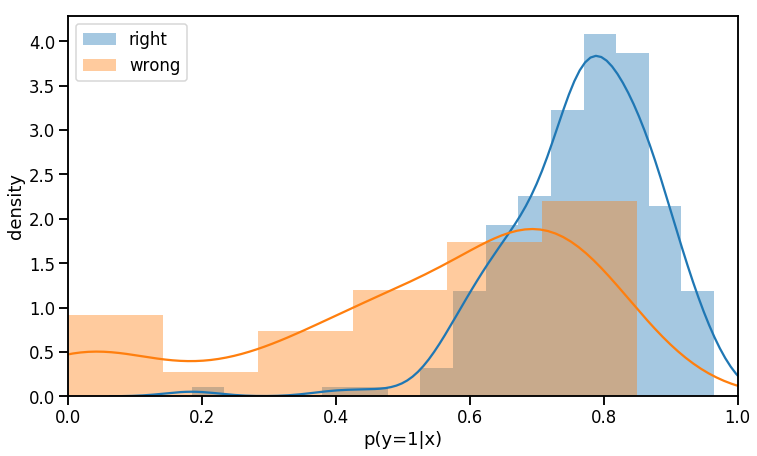

In [17]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(y_pred[y == 1,1], label='right', ax=ax)
sns.distplot(y_pred[y == 0,1], label='wrong', ax=ax)
plt.xlim([0,1])
plt.xlabel('p(y=1|x)')
plt.ylabel('density')
plt.legend();

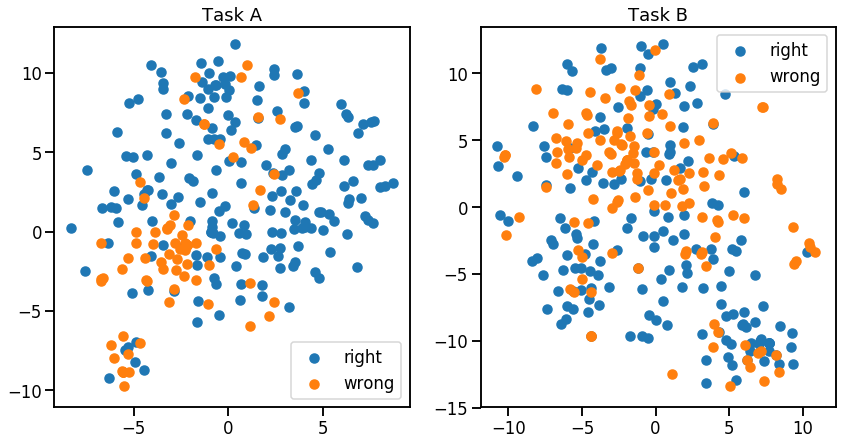

In [18]:
from sklearn.manifold import TSNE

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for ax, (X, y), task in zip(axes.flatten(), [prepare_data('Data A/data_train_A.csv'), prepare_data('Data B/data_train_B.csv')], ['A', 'B']):
    tsne = make_pipeline(
        CountVectorizer(tokenizer=tokenizer),
        TruncatedSVD(100, random_state=42),
        TSNE(random_state=42)
    )

    XX = tsne.fit_transform(X)
    ax.set_title('Task {}'.format(task))
    ax.scatter(*XX[y == 1].T, label='right')
    ax.scatter(*XX[y == 0].T, label='wrong')
    ax.legend();

# Prediction

In [20]:
X_A, y_A = prepare_data('Data A/data_train_A.csv')
X_B, y_B = prepare_data('Data B/data_train_B.csv')

y_A = y_A.astype(int)
y_B = y_B.astype(int)

dev_A = pd.read_csv('Data A/data_test_A.csv').fillna('')
dev_B = pd.read_csv('Data B/data_test_B.csv')

X_dev_A = dev_A['RESPONSE'].values
X_dev_B = dev_B['RESPONSE'].values

In [21]:
model_A = make_pipeline(
    CountVectorizer(tokenizer=tokenizer),
    TruncatedSVD(100, random_state=42),
    RandomForestClassifier(n_estimators=200, random_state=42)
)
model_B = make_pipeline(
    TfidfVectorizer(tokenizer=tokenizer),
    LogisticRegression(solver='lbfgs', random_state=42)
)

for X, y, X_test, y_test, clf in zip([X_A, X_B], [y_A, y_B], [X_dev_A, X_dev_B], [dev_A, dev_B], [model_A, model_B]):
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    y_test['LABEL'] = y_pred

In [22]:
pd.concat([
    dev_A[['RES_ID','LABEL']],
    dev_B[['RES_ID','LABEL']]
]).to_json('test_{}.json'.format(pd.Timestamp.today().strftime('%Y%m%d')), orient='records')